## 1. Imports

In [ ]:
!pip install nlp
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import pandas as pd
import nlp
import spacy
import string
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
directory = '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/Ten Documents'

## 2. Pre-processing

In [ ]:
def get_text_from_txt(filename):
  with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()
    f.close()
  return text

In [ ]:
def print_text(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            text = get_text_from_txt(filepath)
            print(f"File: {filename}")
            print(f"Text: {text}")


print_text(directory)

File: doc1.txt
Text: Source: www.goodreads.com 
List: Best Books of the 20th Century
Title: To Kill a Mockingbird
Author: Harper Lee
Ranking in the List: 1
Rating: 4.26
Genres: Classics, Fiction, Historical Fiction, School, Literature, Young Adult, Historical, Novels, High-School
Total Word Count: 538
Key-Words: bestseller, town, kill, mockingbird, price, love, human, hate, Alabama, kindness, copies, masterpiece, literature, publish, enjoy.
Brief Summary: 
The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. "To Kill A Mockingbird" became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.
Compassionate, dramatic, and deeply moving, "To Kill A Mockingbird" takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pa

In [ ]:
def clean_text(text):
    # Remove new line characters
    text = re.sub(r'\n', ' ', text)

    # Remove apostrophes
    text = re.sub(r"'s", '', text)

    # Remove quotation marks
    text = re.sub(r'\"', '', text)

    # Temporarily replace hyphens within words with a unique token
    text = re.sub(r'(?<=\w)-(?=\w)', 'UNIQUEHYPHEN', text)

    # Temporarily replace URLs with a placeholder
    url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
    urls = url_pattern.findall(text)
    url_dict = {f'URLPLACEHOLDER{i}': url for i, url in enumerate(urls)}
    for placeholder, url in url_dict.items():
        text = text.replace(url, placeholder)

    # Remove all punctuation except the unique hyphen token
    text = text.translate(str.maketrans('', '', string.punctuation.replace('-', '')))

    # Restore the unique token back to hyphens
    text = text.replace('UNIQUEHYPHEN', '-')

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Restore URLs from placeholders
    for placeholder, url in url_dict.items():
        text = text.replace(placeholder, url)

    # Make text lowercase
    text = text.lower()

    return text


In [ ]:
def print_clean_text(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            text = get_text_from_txt(filepath)
            text = clean_text(text)
            print(f"File: {filename}")
            print(f"Text: {text}")


print_clean_text(directory)

File: doc1.txt
Text: source www.goodreads.com list best books of the 20th century title to kill a mockingbird author harper lee ranking in the list 1 rating 426 genres classics fiction historical fiction school literature young adult historical novels high-school total word count 538 key-words bestseller town kill mockingbird price love human hate alabama kindness copies masterpiece literature publish enjoy brief summary the unforgettable novel of a childhood in a sleepy southern town and the crisis of conscience that rocked it to kill a mockingbird became both an instant bestseller and a critical success when it was first published in 1960 it went on to win the pulitzer prize in 1961 and was later made into an academy award-winning film also a classic compassionate dramatic and deeply moving to kill a mockingbird takes readers to the roots of human behavior - to innocence and experience kindness and cruelty love and hatred humor and pathos now with over 18 million copies in print and 

In [ ]:
print('Number of Stop Words: ', len(nlp.Defaults.stop_words))
print(nlp.Defaults.stop_words)

Number of Stop Words:  326
{'an', 'often', 'in', 'top', 'one', 'off', 'itself', 'anywhere', 'becomes', 'those', 'whereas', '’ve', 'are', "'ve", '‘ll', 'whole', 'make', '’ll', "'d", 'therein', 'we', 'anyway', 'six', 'anyhow', 'while', 'mine', 'also', 'were', 'yet', 'during', 'back', 'himself', 'ourselves', 'put', "'s", 'whatever', 'my', 'say', 'neither', 'ten', 'n’t', 'everyone', 'used', 'her', 'you', 'themselves', 'give', 'regarding', 'onto', 'somehow', 'who', 'before', 'nine', 'both', 'among', 'across', 'a', 'has', 'nowhere', 'otherwise', 'moreover', 'whither', 'must', 'where', 'down', 'seems', 'on', '‘re', 'still', 'twenty', 'more', 'yourselves', 'another', 'about', 'might', 'does', 'unless', 'afterwards', 'this', 'from', 'above', 'may', 'because', 'last', 'of', 'could', 'at', 'have', 'too', 'whom', 'formerly', 'four', 'eight', 'except', 'their', 'done', 'twelve', 'us', 'just', 'since', 'then', 'enough', 'various', 'thru', 'via', 'within', 'hers', 'beside', 'else', 'front', 'herself'

## 3. Compute TF-IDF

In [ ]:
def create_noun_phrases(doc):
    noun_phrases = []
    for np in doc.noun_chunks:
        # Exclude noun phrases that contain stop words
        if all(token.lemma_ not in nlp.Defaults.stop_words for token in np):
            noun_phrases.append(np.lemma_)
    return noun_phrases

def create_word_dict_without_stop_words(directory):
    words_dict = defaultdict(int)
    phrases_2 = defaultdict(int)
    phrases_3 = defaultdict(int)

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            text = get_text_from_txt(filepath)
            text = clean_text(text)
            doc = nlp(text)

            # Generate a list of lemmatized tokens from the document, excluding stop words, punctuation, and whitespace
            tokens = [token.lemma_ for token in doc if token.lemma_ not in nlp.Defaults.stop_words and not token.is_punct and not token.is_space]

            # Add word-count pair to the dictionary
            for token in tokens:
                words_dict[token] += 1

            # Extract noun phrases
            noun_phrases = create_noun_phrases(doc)

            # Create and count 2-word and 3-word noun phrases
            for np in noun_phrases:
                np_tokens = np.split()
                if len(np_tokens) == 2:
                    phrases_2[np] += 1
                elif len(np_tokens) == 3:
                    phrases_3[np] += 1

    sorted_words_dict = dict(sorted(words_dict.items(), key=lambda item: item[1], reverse=True))
    sorted_phrases_2 = dict(sorted(phrases_2.items(), key=lambda item: item[1], reverse=True))
    sorted_phrases_3 = dict(sorted(phrases_3.items(), key=lambda item: item[1], reverse=True))

    return sorted_words_dict, sorted_phrases_2, sorted_phrases_3


words_dict, phrases_2, phrases_3 = create_word_dict_without_stop_words(directory)
print("Words:", words_dict)
print("2-word noun phrases:", phrases_2)
print("3-word noun phrases:", phrases_3)

Words: {'novel': 42, 'author': 29, 'fiction': 28, 'story': 28, 'romance': 26, 'love': 25, 'write': 23, 'book': 22, 'historical': 21, 'word': 21, 'list': 20, 'good': 20, 'orwell': 19, 'war': 19, 'century': 17, 'genre': 16, 'publish': 16, 'year': 15, 'time': 15, 'literature': 14, 'writer': 14, 'school': 13, 'title': 12, 'american': 12, 'young': 11, 'key': 11, 'know': 11, 'new': 11, 'work': 11, 'man': 11, 'I': 11, 'mitchell': 11, 'source': 10, 'www.goodreads.com': 10, 'rating': 10, 'classic': 10, 'total': 10, 'count': 10, 'brief': 10, 'summary': 10, 'father': 10, 'mother': 10, 'lee': 9, 'copy': 9, 'tale': 9, 'world': 9, 'twentieth': 9, 'sell': 9, 'river': 9, 'mcnaught': 9, 'rank': 8, 'bestseller': 8, 'woman': 8, 'bear': 8, 'editor': 8, 'science': 8, 'harry': 8, 'begin': 8, 'set': 8, 'gabaldon': 8, 'notebook': 8, 'adult': 7, 'reader': 7, 'language': 7, 'university': 7, 'york': 7, 'long': 7, 'literary': 7, 'civil': 7, 'culture': 7, 'animal': 7, 'popular': 7, 'rowle': 7, 'age': 7, 'whitney':

In [ ]:
# merge the three dictionaries into the words_dict
words_dict.update(phrases_2)
words_dict.update(phrases_3)
# sort the dictionary
sorted_words_dict = dict(sorted(words_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_words_dict)


{'novel': 42, 'author': 29, 'fiction': 28, 'story': 28, 'romance': 26, 'love': 25, 'write': 23, 'book': 22, 'historical': 21, 'word': 21, 'list': 20, 'good': 20, 'orwell': 19, 'war': 19, 'century': 17, 'genre': 16, 'publish': 16, 'year': 15, 'time': 15, 'literature': 14, 'writer': 14, 'school': 13, 'title': 12, 'american': 12, 'young': 11, 'key': 11, 'know': 11, 'new': 11, 'work': 11, 'man': 11, 'I': 11, 'mitchell': 11, 'source': 10, 'www.goodreads.com': 10, 'rating': 10, 'classic': 10, 'total': 10, 'count': 10, 'brief': 10, 'summary': 10, 'father': 10, 'mother': 10, 'lee': 9, 'copy': 9, 'tale': 9, 'world': 9, 'twentieth': 9, 'sell': 9, 'river': 9, 'mcnaught': 9, 'rank': 8, 'bestseller': 8, 'woman': 8, 'bear': 8, 'editor': 8, 'science': 8, 'harry': 8, 'begin': 8, 'set': 8, 'gabaldon': 8, 'notebook': 8, 'total word': 8, 'adult': 7, 'reader': 7, 'language': 7, 'university': 7, 'york': 7, 'long': 7, 'literary': 7, 'civil': 7, 'culture': 7, 'animal': 7, 'popular': 7, 'rowle': 7, 'age': 7, 

In [ ]:
# Compute total words in the document
print('Total number of words and noun-phrases in the lexicon:', len(sorted_words_dict))

Total number of words and noun-phrases in the lexicon: 1461


In [ ]:
# Total number of documents in the corpus
total_docs = 10

# Compute total words in the documents
total_words = sum(sorted_words_dict.values())

# Each word appears in at least one document
doc_freq = {word: 1 for word in sorted_words_dict}

# Compute TF, IDF, and TF-IDF
tf_idf_dict = {}
for word, count in sorted_words_dict.items():
    tf = count / total_words
    idf = math.log(total_docs / (1 + doc_freq[word]))
    tf_idf_dict[word] = tf * idf

# Print the TF-IDF values
print(tf_idf_dict)

{'novel': 0.02122335708704308, 'author': 0.014654222750577364, 'fiction': 0.014148904724695387, 'story': 0.014148904724695387, 'romance': 0.013138268672931433, 'love': 0.012632950647049451, 'write': 0.011622314595285496, 'book': 0.011116996569403518, 'historical': 0.01061167854352154, 'word': 0.01061167854352154, 'list': 0.010106360517639563, 'good': 0.010106360517639563, 'orwell': 0.009601042491757583, 'war': 0.009601042491757583, 'century': 0.008590406439993627, 'genre': 0.00808508841411165, 'publish': 0.00808508841411165, 'year': 0.007579770388229671, 'time': 0.007579770388229671, 'literature': 0.007074452362347694, 'writer': 0.007074452362347694, 'school': 0.006569134336465716, 'title': 0.006063816310583737, 'american': 0.006063816310583737, 'young': 0.005558498284701759, 'key': 0.005558498284701759, 'know': 0.005558498284701759, 'new': 0.005558498284701759, 'work': 0.005558498284701759, 'man': 0.005558498284701759, 'I': 0.005558498284701759, 'mitchell': 0.005558498284701759, 'sour

In [ ]:
# create the dataframe
tf_idf_df = pd.DataFrame(tf_idf_dict.items(), columns=['Word', 'TF-IDF'])
tf_idf_df['Word Count'] = [sorted_words_dict[word] for word in tf_idf_df['Word']]
tf_idf_df = tf_idf_df[['Word', 'Word Count', 'TF-IDF']]
print(tf_idf_df.shape)
print(tf_idf_df.head(25))

(1461, 3)
          Word  Word Count    TF-IDF
0        novel          42  0.021223
1       author          29  0.014654
2      fiction          28  0.014149
3        story          28  0.014149
4      romance          26  0.013138
5         love          25  0.012633
6        write          23  0.011622
7         book          22  0.011117
8   historical          21  0.010612
9         word          21  0.010612
10        list          20  0.010106
11        good          20  0.010106
12      orwell          19  0.009601
13         war          19  0.009601
14     century          17  0.008590
15       genre          16  0.008085
16     publish          16  0.008085
17        year          15  0.007580
18        time          15  0.007580
19  literature          14  0.007074
20      writer          14  0.007074
21      school          13  0.006569
22       title          12  0.006064
23    american          12  0.006064
24       young          11  0.005558


In [ ]:
# top ten of tf_idf_df
top_ten = tf_idf_df.nlargest(10, 'TF-IDF')
print(top_ten)

         Word  Word Count    TF-IDF
0       novel          42  0.021223
1      author          29  0.014654
2     fiction          28  0.014149
3       story          28  0.014149
4     romance          26  0.013138
5        love          25  0.012633
6       write          23  0.011622
7        book          22  0.011117
8  historical          21  0.010612
9        word          21  0.010612


In [ ]:
# last ten of tf_idf_df
last_20 = tf_idf_df.nsmallest(20, 'TF-IDF')
print(last_20)

              Word  Word Count    TF-IDF
584            538           1  0.000505
585          price           1  0.000505
586  unforgettable           1  0.000505
587         sleepy           1  0.000505
588         crisis           1  0.000505
589     conscience           1  0.000505
590           rock           1  0.000505
591        instant           1  0.000505
592        academy           1  0.000505
593       dramatic           1  0.000505
594           root           1  0.000505
595      innocence           1  0.000505
596        cruelty           1  0.000505
597         pathos           1  0.000505
598             18           1  0.000505
599       regional           1  0.000505
600          claim           1  0.000505
601      universal           1  0.000505
602         appeal           1  0.000505
603         simple           1  0.000505


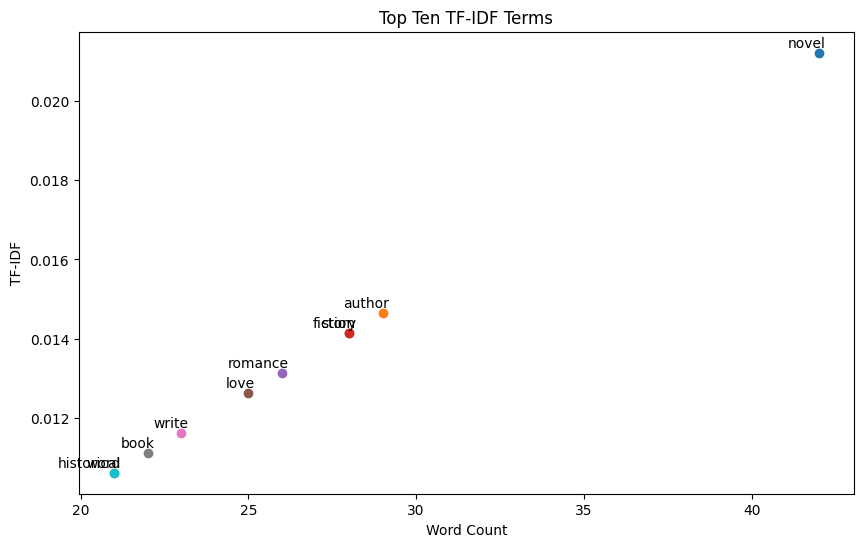

In [ ]:
# Plot the top ten terms
plt.figure(figsize=(10, 6))

# Plot each point
for idx, row in top_ten.iterrows():
    plt.scatter(row['Word Count'], row['TF-IDF'])
    plt.annotate(row['Word'], xy=(row['Word Count'], row['TF-IDF']), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title('Top Ten TF-IDF Terms')
plt.xlabel('Word Count')
plt.ylabel('TF-IDF')
plt.show()
